In [324]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import os
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split as tts


In [216]:
os.chdir(r"C:\Users\Shardul Janaskar\Downloads\lda_amazon")

In [217]:
df = pd.read_csv('reviews_sample.csv')

In [218]:
df = df.drop(['Unnamed: 0','review_link','review_votes','sentiment','author','instance_id','id','review_date','review_header','verified_purchase'],1)

In [219]:
df = df[df.rating != 3]

In [220]:
def partition(x):
    if x < 3:
        return 'negative'
    else:
        return 'positive'
    

filtered_df = df['rating']
df1 = filtered_df.map(partition)
df['pos_neg'] = df1

In [221]:
df = df.dropna() 

In [222]:
df = df.drop('rating',1)

In [223]:
df.shape

(89, 2)

In [224]:
df['pos_neg'].value_counts()


positive    81
negative     8
Name: pos_neg, dtype: int64

In [225]:
smt = SMOTE()

In [232]:
import re
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
wnl= WordNetLemmatizer()
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', str(doc))
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    #Lemmetization
    lem_tokens = [wnl.lemmatize(word, pos="v") for word in filtered_tokens]
    # re-create document from filtered tokens
    doc = ' '.join(lem_tokens)
    return doc

In [233]:
normalize_corpus = np.vectorize(normalize_document)

In [234]:
text = df['review_body']

In [244]:
norm_corp = normalize_corpus(text)

In [253]:
# X = df.drop('pos_neg',1)
y = df['pos_neg'].map({'positive' : 1, 'negative' : 0})

In [258]:
X_train, X_test, y_train, y_test = tts(norm_corp,y,test_size=0.2, random_state=42)

In [259]:
cv = CountVectorizer()
X_train1 = cv.fit_transform(X_train)
X_test1 = cv.transform(X_test)

In [260]:
X_train1.shape

(71, 402)

In [264]:
from sklearn.naive_bayes import MultinomialNB

In [265]:
nb = MultinomialNB()

In [266]:
nb.fit(X_train1,y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [267]:
tvec = TfidfVectorizer(max_features=100000)

In [268]:
nb.predict(X_test1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [289]:
X = norm_corp

In [290]:
Xtrain = tvec.fit_transform(X)

In [292]:
X_SMOTE, y_SMOTE = smt.fit_sample(Xtrain, y)

In [293]:
new_df = pd.DataFrame(X_SMOTE.todense(), columns=tvec.get_feature_names())

In [294]:
X_trains, X_tests, y_trains, y_tests = tts(X_SMOTE, y_SMOTE,test_size=0.2, random_state=42 )


In [295]:
nb.fit(X_trains, y_trains)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [296]:
y_preds = nb.predict(X_tests)

In [297]:
from sklearn.metrics import accuracy_score
accuracy_score(y_tests, y_preds)

0.8181818181818182

In [298]:
from sklearn.linear_model import LogisticRegression

In [303]:
lr = LogisticRegression()

In [304]:
lr.fit(X_trains,y_trains)

C:\Users\Shardul Janaskar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [305]:
y_predict = lr.predict(X_tests)

In [306]:
accuracy_score(y_tests, y_predict)

1.0

In [308]:
from sklearn.svm import SVC

In [309]:
sv = SVC()

In [310]:
sv.fit(X_trains,y_trains)

C:\Users\Shardul Janaskar\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [312]:
pred = sv.predict(X_tests)

In [313]:
accuracy_score(y_tests, pred)

0.48484848484848486

In [314]:
from xgboost import XGBClassifier

In [315]:
xg = XGBClassifier()

In [316]:
xg.fit(X_trains,y_trains)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [317]:
xg_pred = xg.predict(X_tests)

In [318]:
accuracy_score(y_tests,xg_pred)

0.9090909090909091

In [328]:
from keras.models import Sequential

In [329]:
from keras import layers


In [331]:
input_dim = X_trains.shape[1]

In [332]:
from keras.utils.np_utils import to_categorical
y_train_cat = to_categorical(y_trains)
y_test_cat = to_categorical(y_tests)

In [333]:
model = Sequential()

In [334]:
model.add(layers.Dense(10,input_dim = input_dim, activation='relu'))
model.add(layers.Dense(2, activation="softmax"))

In [336]:
model.compile(loss = 'categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [342]:
history = model.fit(X_trains, y_train_cat, epochs=50, validation_split=0.1, batch_size=10)

Train on 116 samples, validate on 13 samples
Epoch 1/50
116/116 [==============================] - 0s 285us/step - loss: 0.0159 - acc: 1.0000 - val_loss: 0.0359 - val_acc: 1.0000
Epoch 2/50
116/116 [==============================] - 0s 276us/step - loss: 0.0152 - acc: 1.0000 - val_loss: 0.0346 - val_acc: 1.0000
Epoch 3/50
116/116 [==============================] - 0s 328us/step - loss: 0.0146 - acc: 1.0000 - val_loss: 0.0337 - val_acc: 1.0000
Epoch 4/50
116/116 [==============================] - 0s 354us/step - loss: 0.0140 - acc: 1.0000 - val_loss: 0.0325 - val_acc: 1.0000
Epoch 5/50
116/116 [==============================] - 0s 302us/step - loss: 0.0135 - acc: 1.0000 - val_loss: 0.0315 - val_acc: 1.0000
Epoch 6/50
116/116 [==============================] - 0s 319us/step - loss: 0.0130 - acc: 1.0000 - val_loss: 0.0306 - val_acc: 1.0000
Epoch 7/50
116/116 [==============================] - 0s 362us/step - loss: 0.0125 - acc: 1.0000 - val_loss: 0.0298 - val_acc: 1.0000
Epoch 8/50
116/11

In [343]:
loss, accuracy = model.evaluate(X_trains, y_train_cat, verbose=False)
print ("Training Accuracy:",accuracy)
print ("Training Loss:", loss)

Training Accuracy: 1.0
Training Loss: 0.004561170899533024


In [344]:
loss, accuracy = model.evaluate(X_tests, y_test_cat, verbose=False)
print ("Testing Accuracy:",accuracy)
print ("Testing Loss:", loss)

Testing Accuracy: 1.0
Testing Loss: 0.06228648487365607


In [352]:
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1,len(accuracy)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(x,accuracy,"b", label="Training_Acc")
    plt.plot(x,val_acc,"r", label="Validation_Acc")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(x,loss,"b", label="Training_Acc")
    plt.plot(x,val_loss,"r", label="Validation_Acc")
    plt.title("Training and Validation Loss")
    plt.legend()

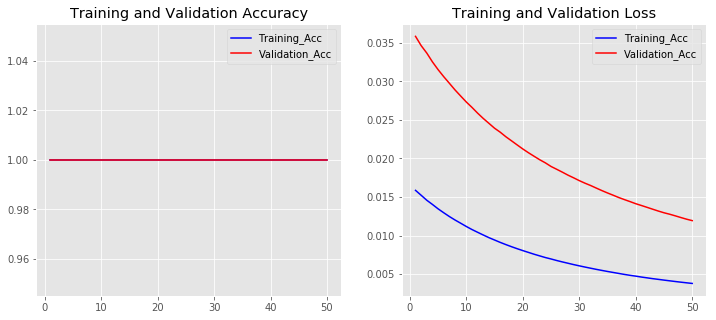

In [353]:
plot_history(history)

In [365]:
sentences = df["review_body"].values
y = df["pos_neg"].map({'positive':1,'negative':0}).values
 
sentences_train, sentences_test, y_train, y_test = tts(sentences, y, test_size=0.25, random_state=1000)

from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index)+1 # adding 1 because of reserved 0 index

print (sentences_train[2])
print (X_train[2])

I personally only use it for playing Spotify, didn't really use it for anything else.
[3, 193, 59, 20, 4, 6, 194, 195, 124, 50, 20, 4, 6, 75, 196]


In [366]:
from keras.preprocessing.sequence import pad_sequences
maxlen=100
X_train = pad_sequences(X_train, padding = "post", maxlen= maxlen)
X_test = pad_sequences(X_test, padding = "post", maxlen=maxlen)

print(X_train[0,:])

[ 12   1  25 121   3 188  95   4   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [367]:
from keras.models import Sequential
from keras import layers
embedding_dim = 50

In [368]:
model= Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim= embedding_dim, input_length=maxlen))

In [369]:
model.add(layers.Flatten())
model.add(layers.Dense(10, activation = "relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics = ["accuracy"])

In [370]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           25900     
_________________________________________________________________
flatten_2 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 75,921
Trainable params: 75,921
Non-trainable params: 0
_________________________________________________________________


In [371]:
h= model.fit(X_train, y_train, batch_size=20, epochs=20, verbose=1, validation_data=(X_test, y_test))


Train on 66 samples, validate on 23 samples
Epoch 1/20
66/66 [==============================] - 3s 44ms/step - loss: 0.5996 - acc: 0.9091 - val_loss: 0.5001 - val_acc: 0.8696
Epoch 2/20
66/66 [==============================] - 0s 470us/step - loss: 0.3761 - acc: 0.9394 - val_loss: 0.4286 - val_acc: 0.8696
Epoch 3/20
66/66 [==============================] - 0s 546us/step - loss: 0.2820 - acc: 0.9394 - val_loss: 0.4510 - val_acc: 0.8696
Epoch 4/20
66/66 [==============================] - 0s 349us/step - loss: 0.2457 - acc: 0.9394 - val_loss: 0.5012 - val_acc: 0.8696
Epoch 5/20
66/66 [==============================] - 0s 379us/step - loss: 0.2579 - acc: 0.9394 - val_loss: 0.5352 - val_acc: 0.8696
Epoch 6/20
66/66 [==============================] - 0s 804us/step - loss: 0.2574 - acc: 0.9394 - val_loss: 0.5288 - val_acc: 0.8696
Epoch 7/20
66/66 [==============================] - 0s 303us/step - loss: 0.2421 - acc: 0.9394 - val_loss: 0.4979 - val_acc: 0.8696
Epoch 8/20
66/66 [===============

In [372]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print ("Training Accuracy:",accuracy)
print ("Training Loss:", loss)

Training Accuracy: 0.9393939393939394
Training Loss: 0.10031522765304103


In [373]:
loss_test, accuracy_test = model.evaluate(X_test, y_test, verbose=False)

In [375]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print ("Testing Accuracy:",accuracy)
print ("Testing Loss:", loss)

Testing Accuracy: 0.8695651888847351
Testing Loss: 0.41191962361335754


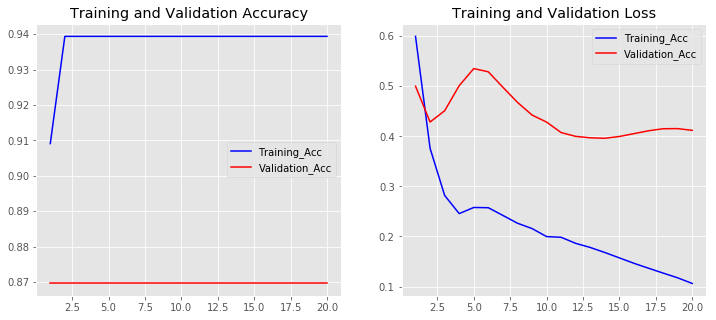

In [376]:
plot_history(h)

In [377]:
embedding_dim = 100

In [378]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length= maxlen))
model.add(layers.Conv1D(128, 10, activation = "relu"))
model.add(layers.Conv1D(100, 10, activation = "relu"))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation = "relu"))
model.add(layers.Dense(1, activation = "sigmoid"))
model.compile(optimizer="adam", loss ="binary_crossentropy",metrics =["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          51800     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 91, 128)           128128    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 82, 100)           128100    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 309,049
Trainable params: 309,049
Non-trainable params: 0
_________________________________________________________________


In [379]:
history = model.fit(X_train, y_train, epochs=10, verbose=False, validation_data= (X_test, y_test), batch_size=10)

In [380]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)

In [381]:
print ("Training Accuracy:{:4f}".format(accuracy))

Training Accuracy:0.954545


In [382]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=False)

In [383]:
print ("Test Accuracy:{:4f}".format(test_accuracy))

Test Accuracy:0.869565


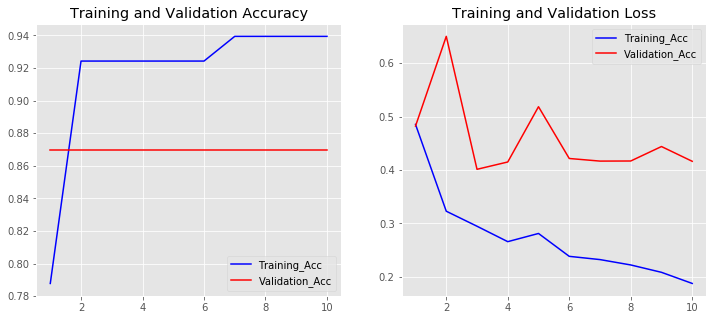

In [384]:
plot_history(history)